# 0. Import libraries

The libraries used to create the data are in the following cell

In [1]:
# Official libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd

# Project utils libraries
from surfaces import *
from constants import *


# 1. Define constants

This section defines constants to be used in the notebook

In [2]:
# Path constants
DATA_FOLDER_PATH = "./Data"
FEATURES_FILENAME = "surfaces.npy"
LABELS_FILENAME = "coefficients.npy"

FEATURES_FILE_PATH = f"{DATA_FOLDER_PATH}/{FEATURES_FILENAME}"
LABELS_FILE_PATH = f"{DATA_FOLDER_PATH}/{LABELS_FILENAME}"

# 2. Compile functions

This section has all the necessary functions to create the surfaces based on the Zernike polynomials

In [3]:
def compute_surface_value_at_point(rho,
                                   varphi,
                                   zernike_polynomials,
                                   verbose=False):
    """
    Function to compute the z value of a surface at a point given zernike coefficients and polar coordinates of point
    
    Input:
        rho (float): The distance of the point to the center (radius in polar coordinates) 
        varphi(float): The angle of the point with respect to x-axis (angle in polar coordinates)
        zernike_polynomials (list): A list of tuples with zernike polynomials info (m_index, n_index, coefficient)
        verbose (bool): Optional. True if more verbosity for errors
        
    Returns:
        z_value (float): The value of the surface at the point
    """
    
    # Initialize the z value of the point
    z_value = 0
    
    # For compute the point value on each zernike polynomials and add them all with a weighted sum
    for m_index, n_index, coefficient in zernike_polynomials:
        actual_value = compute_zernike_polynomial_at_point(m_index,
                                                           n_index,
                                                           rho,
                                                           varphi,
                                                           verbose=verbose)
        weighted_value = coefficient * actual_value
        z_value += weighted_value
        
    return z_value


def generate_data_for_training(n_data,
                               verbose=False):
    """
    Generates a dataframe with data for training
    
    Input:
        n_data (int): Number of data points to train (A data point consisting on a surface and its zernike coefficients)
        verbose (bool): Optional. True if more verbosity for errors
        
    Returns:
        surface_dataframe (pd.DataFrame): A dataframe with columns 'surface_values' and 'zernike_coefficients' contaning arrays
    """
    
    surface_list = []
    coefficient_list = []
    
    for i in range(0, n_data):
        # Get the zernike polynomials with their coefficients
        zernike_polynomials = get_random_zernike_coefficients()
        
        # Get the points polar coordinates to sample from the surface created by the zernike polynomials
        rho_coordinates, varphi_coordinates = polar_samples_unit_circle_for_data_generation()
        
        # Compute the values of the surface at the points
        surface_values = sample_z_from_surface(rho_coordinates,
                                               varphi_coordinates,
                                               zernike_polynomials,
                                               verbose=verbose)
        
        # Append the surface values to the surface list
        surface_list.append(surface_values)
        
        # Get last element (zernike coefficient) of the zernike polynomials tuples to store them in the dataframe
        coefficients = list(map(lambda x: x[-1], zernike_polynomials))
        
        # Convert the list to a numpy array
        np_coefficients = np.array(coefficients)
        
        # Append the surface zernike coefficients to the list of coefficients
        coefficient_list.append(np_coefficients)
    
    # Create the dataframe and add the data
    np.save(FEATURES_FILE_PATH, surface_list)
    np.save(LABELS_FILE_PATH, coefficient_list)
    return None

# 3. The process of generating data

We will be generating random surfaces using the basis of the **first 19 zernike polynomials**.

In the first place we will sample points from the unit disk in polar coordinates

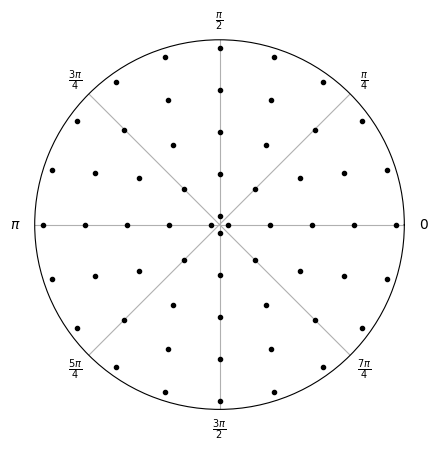

In [4]:
rho_array, varphi_array = polar_samples_unit_circle_for_data_generation()
plot_2d_polar_points(rho_array, varphi_array)

Then we will get random zernike coefficients for each polynomial that describe a random surface

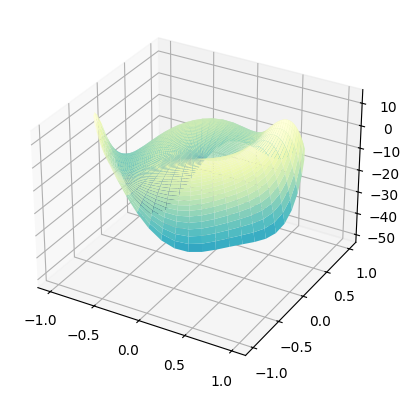

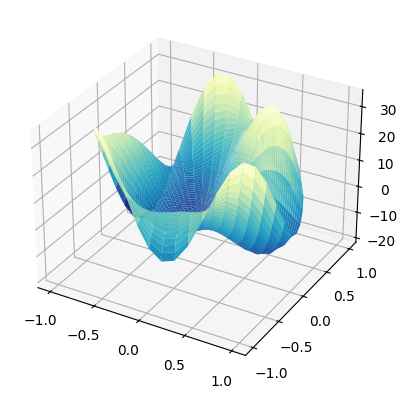

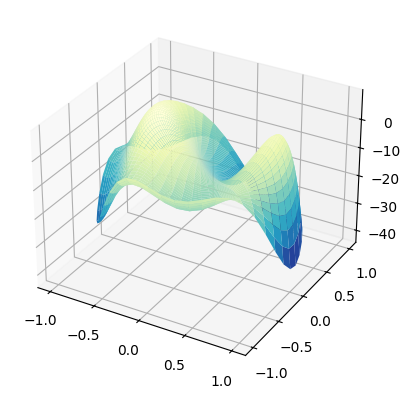

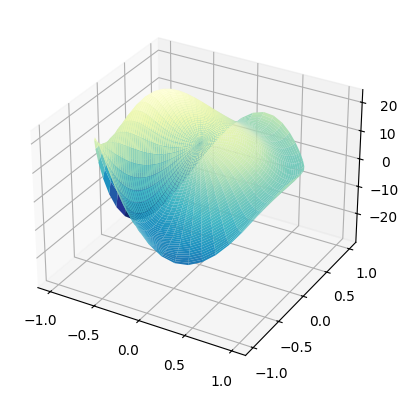

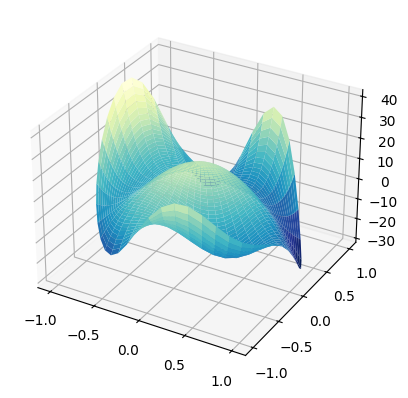

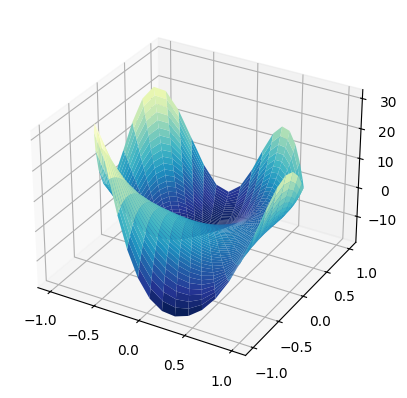

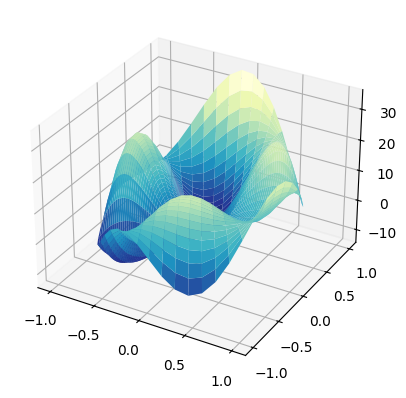

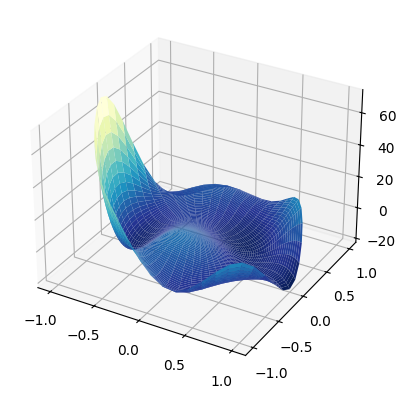

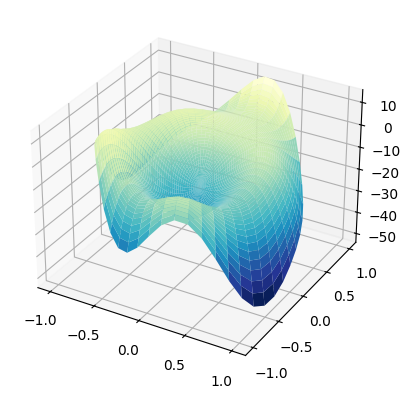

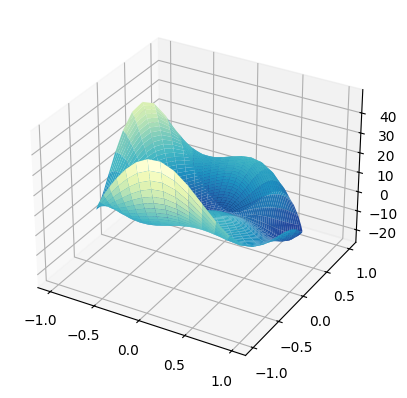

In [8]:
for i in range(0, 10):
    zernike_polynomials = get_random_zernike_coefficients()
    plot_surface(zernike_polynomials)

We will repeat this process a number of times and store the z values of the surface and its zernike coefficients in a pandas dataframe

In [6]:
n_surfaces = 3
generate_data_for_training(n_surfaces,
                           verbose=True)

# 4. Data genation

We will create 60.000 data points

In [7]:
n_surfaces = 60000
surfaces_dataframe = generate_data_for_training(n_surfaces,
                                                verbose=True)